# Test de différentes technique de démodulation pour RVDT et LVDT

## Simulation d'une RVDT/LVDT

1.9021093269313993
1.9021130325888715


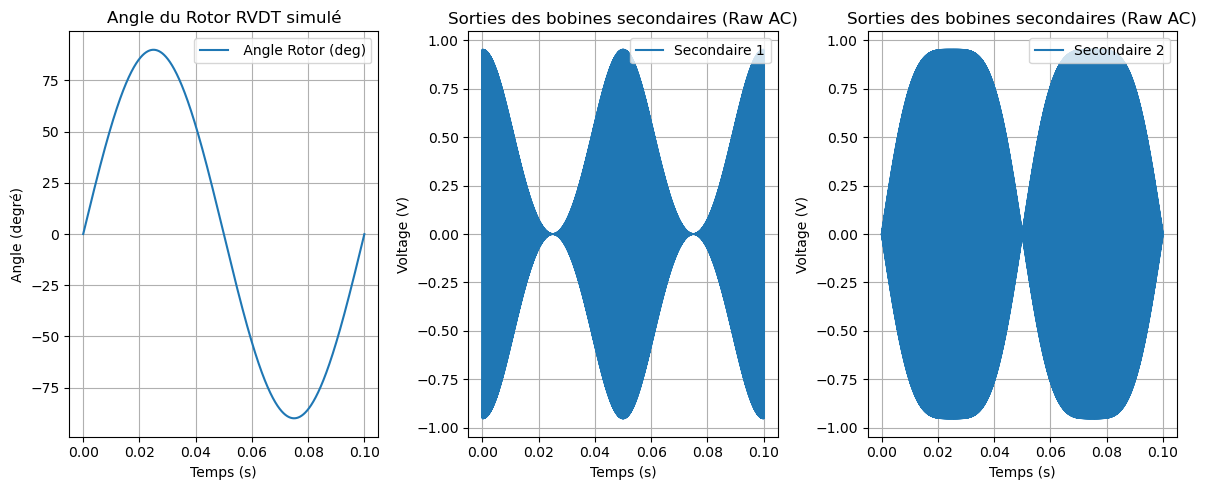

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_rvdt(
    sample_rate=10000000,
    duration=0.02,
    exc_freq=10000,
    angle_freq=10,
    max_angle_deg=20,
    gain=1.0,
    phase_shift_deg=0.0,
    noise_std=0.0
):

    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    angle_deg_shifted = max_angle_deg * np.sin(2 * np.pi * angle_freq * t + np.deg2rad(phase_shift_deg))
    angle_deg = max_angle_deg * np.sin(2 * np.pi * angle_freq * t)

    angle_rad_shifted = np.deg2rad(angle_deg_shifted)
    angle_rad = np.deg2rad(angle_deg)
    
    carrier = np.sin(2 * np.pi * exc_freq * t)
    
    s1_amplitude = gain * np.cos(angle_rad_shifted)
    s2_amplitude = gain * np.sin(angle_rad)
    
    s1 = s1_amplitude * carrier
    s2 = s2_amplitude * carrier

    ptp_s1 = np.ptp(s1)
    ptp_s2 = np.ptp(s2) 
    print(ptp_s1)
    print(ptp_s2)
    if noise_std > 0:
        noise_level_s1 = noise_std / 100.0 * ptp_s1
        noise_level_s2 = noise_std / 100.0 * ptp_s2
        s1 += np.random.normal(0, noise_level_s1, size=len(s1))
        s2 += np.random.normal(0, noise_level_s2, size=len(s2))
    
    return t, angle_deg, s1, s2


fs         = 100000   
exc_freq   = 10000    
duration   = 0.1        
angle_freq = 10        
max_angle_deg = 90        

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=0.0,
    noise_std=0.0
)
    
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))  

axs[0].plot(t, angle_deg, label=" Angle Rotor (deg)")
axs[0].set_xlabel("Temps (s)")
axs[0].set_ylabel("Angle (degré)")
axs[0].set_title("Angle du Rotor RVDT simulé")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, s1, label="Secondaire 1")
axs[1].set_xlabel("Temps (s)")
axs[1].set_ylabel("Voltage (V)")
axs[1].set_title("Sorties des bobines secondaires (Raw AC)")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(t, s2, label="Secondaire 2")
axs[2].set_xlabel("Temps (s)")
axs[2].set_ylabel("Voltage (V)")
axs[2].set_title("Sorties des bobines secondaires (Raw AC)")
axs[2].legend()
axs[2].grid(True)


plt.tight_layout()
plt.show()


## CIC filter

In [11]:
# https://www.gibbard.me/cic_filters/cic_filters_ipython.html
def comb(inData, D):
    outData = []
    delay = [0] * D
    for sample in inData:
        outData.append(sample - delay[-1])
        delay = [sample] + delay
        delay.pop()
    return np.asarray(outData)

def integrator(inData):
    delay = 0
    outData = []
    for sample in inData:
        y = delay + sample    
        outData.append(y)
        delay = y
    return np.asarray(outData)
#  where R = decimation factor, M = Differential delay, and N = CIC order
def cic_decimate(x, R, N=3, M=1):
    y = x.astype(np.float64)
    for _ in range(N):
        y = integrator(y)

    y = y[::R]

    for _ in range(N):
        y = comb(y, M)

    return y / (R * M) ** N

## Hilbert

### fonctionnement normal

3.999999398709824
1.3680789546156924


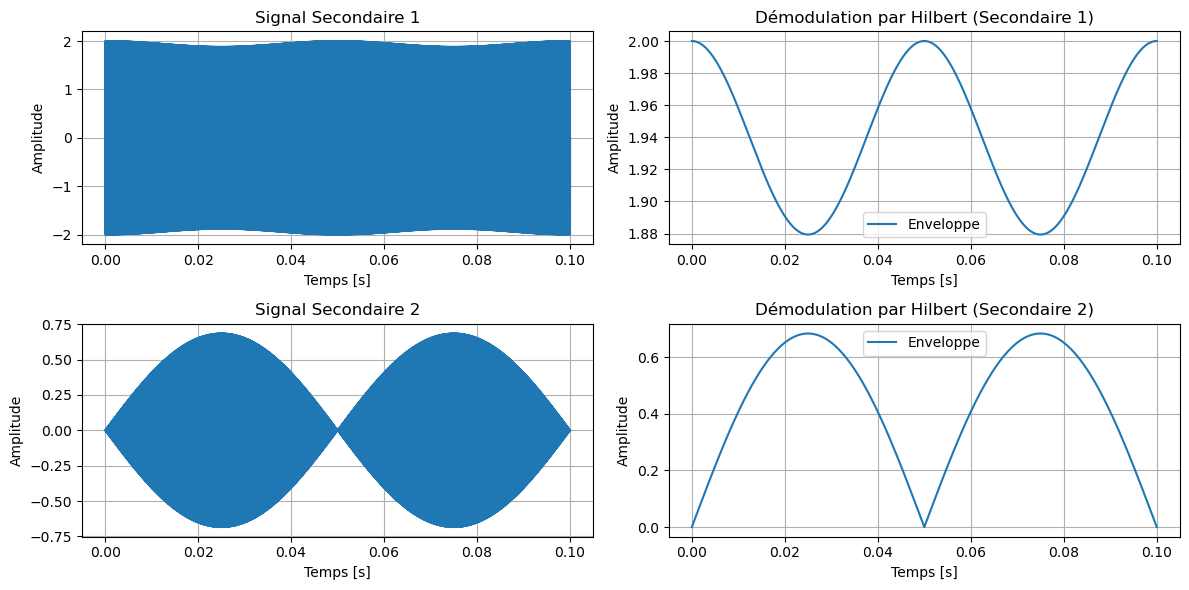

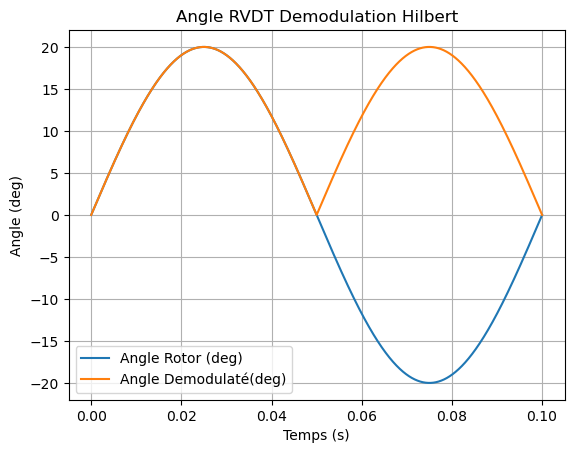

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1        
angle_freq = 10        
max_angle_deg = 20      


t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=0.0,
    noise_std=0.0
)

cosinus = hilbert(s1)
sinus = hilbert(s2)

cosinus_envelope = np.abs(cosinus)
sinus_envelope = np.abs(sinus)

demod_angle_rad = np.arctan2(sinus_envelope, cosinus_envelope)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(t, cosinus_envelope, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Hilbert (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(t, sinus_envelope, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Hilbert (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Simulated RVDT Rotor Angle")
plt.grid(True)
plt.legend()

plt.plot(t, demod_angle_deg, label="Angle Demodulaté(deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle RVDT Demodulation Hilbert")
plt.grid(True)
plt.legend()


### fonctionnement avec bruit

1.90211284959472
0.6505604794000491


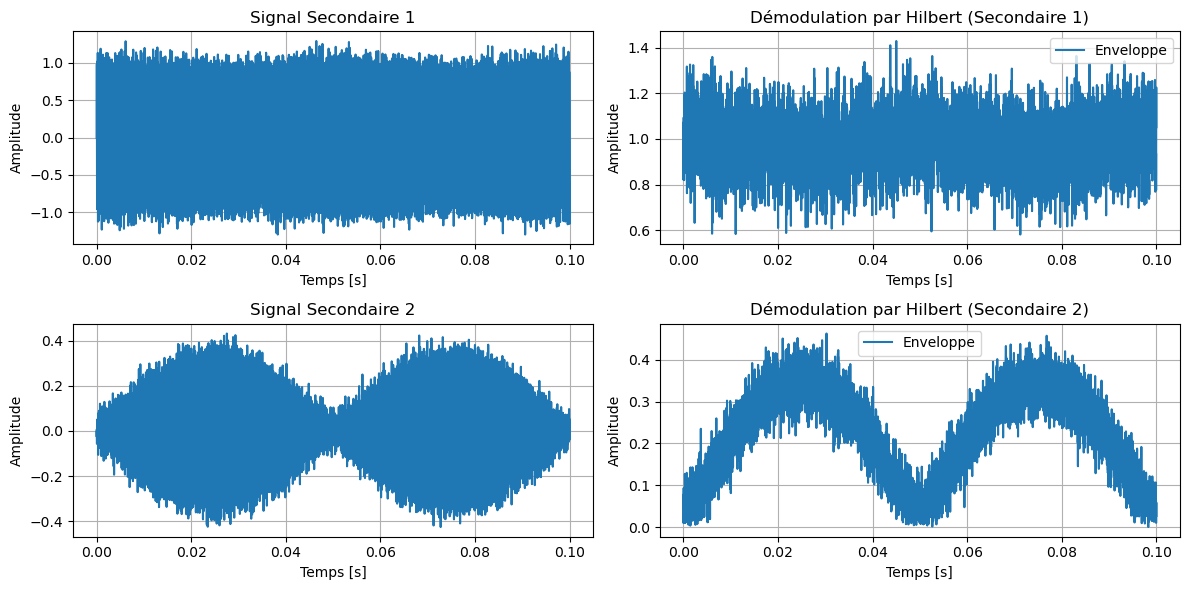

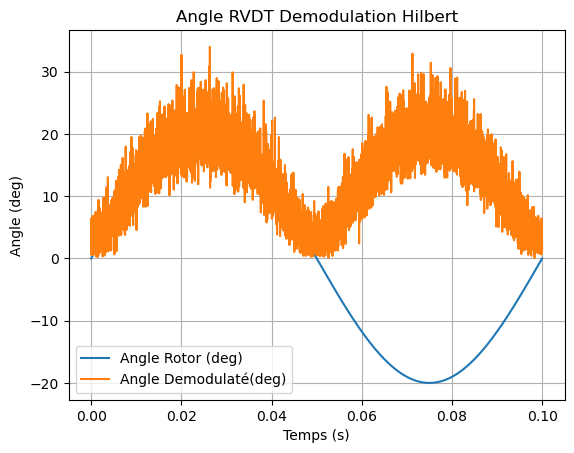

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

fs         = 100000   
exc_freq   = 10000    
duration   = 0.1        
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 0.0
noise_std = 6.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

cosinus = hilbert(s1)
sinus = hilbert(s2)

cosinus_envelope = np.abs(cosinus)
sinus_envelope = np.abs(sinus)

demod_angle_rad = np.arctan2(sinus_envelope, cosinus_envelope)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(t, cosinus_envelope, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Hilbert (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(t, sinus_envelope, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Hilbert (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Simulated RVDT Rotor Angle")
plt.grid(True)
plt.legend()

plt.plot(t, demod_angle_deg, label="Angle Demodulaté(deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle RVDT Demodulation Hilbert")
plt.grid(True)
plt.legend()


### fonctionnement avec phase shift

1.999999699354912
0.6840394773078462


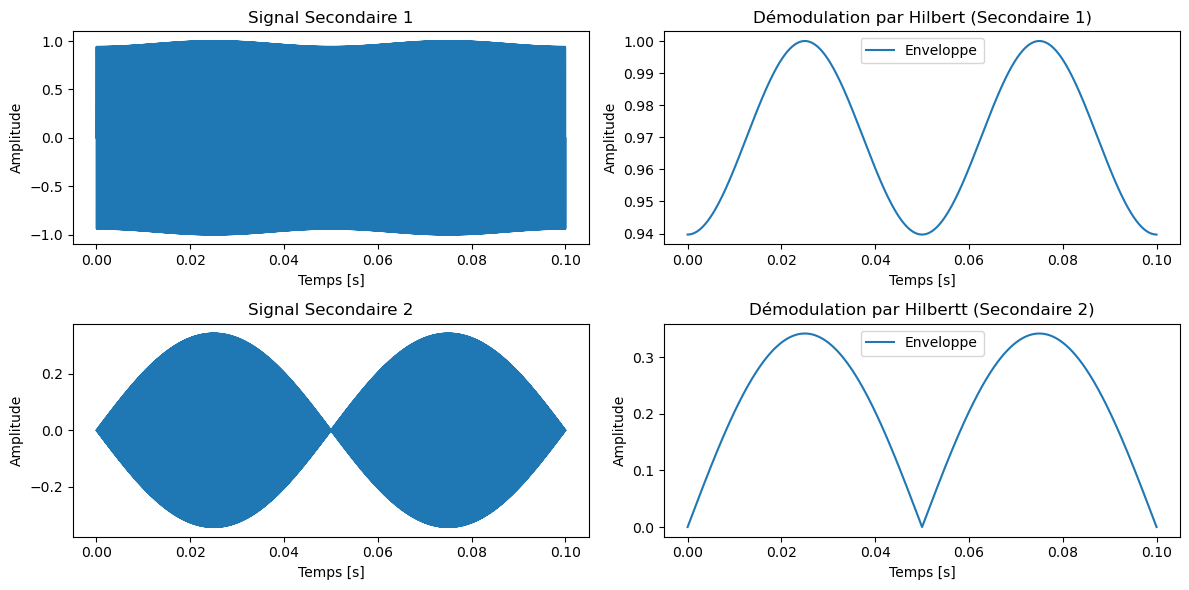

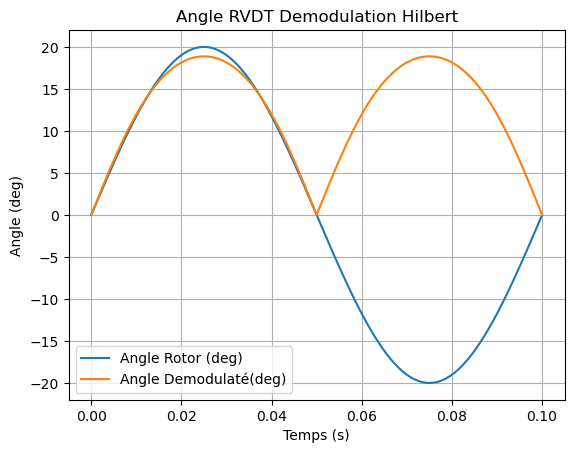

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1        
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 90.0
noise_std = 0.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

cosinus = hilbert(s1)
sinus = hilbert(s2)

cosinus_envelope = np.abs(cosinus)
sinus_envelope = np.abs(sinus)

demod_angle_rad = np.arctan2(sinus_envelope, cosinus_envelope)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")

axs[0, 1].plot(t, cosinus_envelope, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Hilbert (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")

axs[1, 1].plot(t, sinus_envelope, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Hilbertt (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Simulated RVDT Rotor Angle")
plt.grid(True)
plt.legend()

plt.plot(t, demod_angle_deg, label="Angle Demodulaté(deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle RVDT Demodulation Hilbert")
plt.grid(True)
plt.legend()

### fonctionnement avec phase shift et noise

1.9999996845083046
0.6840394773078462


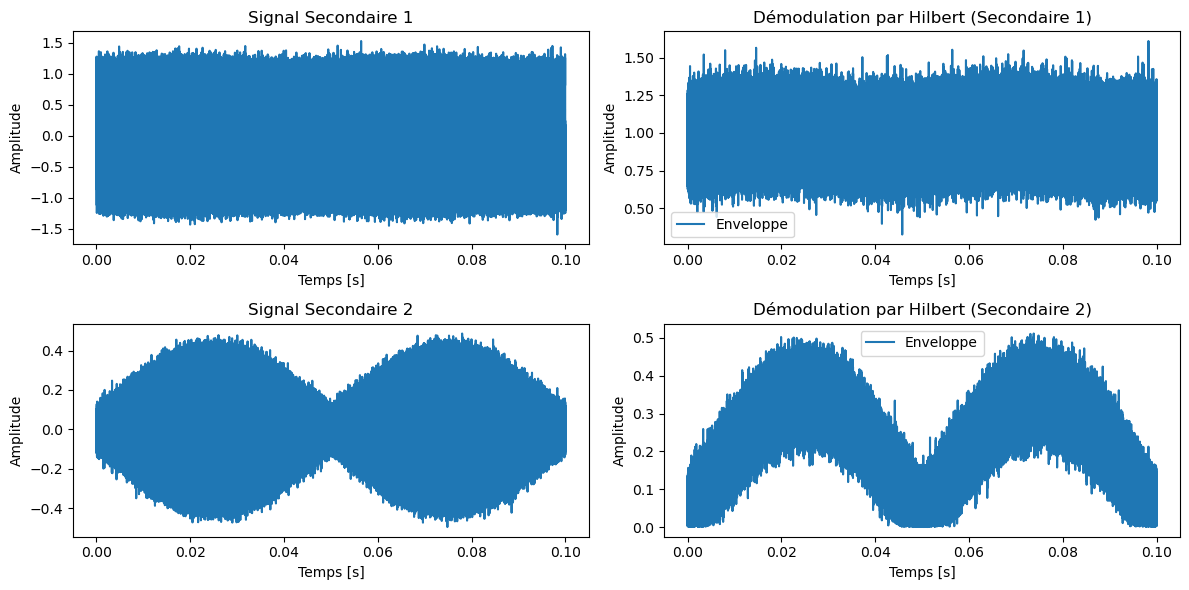

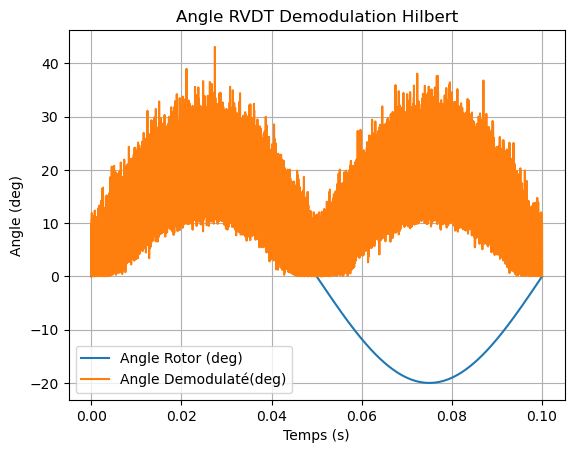

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

fs         = 10000000
exc_freq   = 10000
duration   = 0.1
angle_freq = 10
max_angle_deg = 20
phase_shift_deg = 115.0
noise_std = 6.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

cosinus = hilbert(s1)
sinus = hilbert(s2)

cosinus_envelope = np.abs(cosinus)
sinus_envelope = np.abs(sinus)

demod_angle_rad = np.arctan2(sinus_envelope, cosinus_envelope)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")

axs[0, 1].plot(t, cosinus_envelope, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Hilbert (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")

axs[1, 1].plot(t, sinus_envelope, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Hilbert (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Simulated RVDT Rotor Angle")
plt.grid(True)
plt.legend()

plt.plot(t, demod_angle_deg, label="Angle Demodulaté(deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle RVDT Demodulation Hilbert")
plt.grid(True)
plt.legend()

## Quadrature

### Quadrature function

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter, medfilt
import scipy.signal as si

# see this link https://dsp.stackexchange.com/questions/27446/doing-analysis-using-iq-demodulation-in-python

def quadrature_demod(signal, carrier_freq, fs, R, N, M):
    n = len(signal)
    t = np.arange(n) / fs
    
    I = signal * np.cos(2*np.pi*carrier_freq*t)
    Q = signal * np.sin(2*np.pi*carrier_freq*t)
    
    I_filt = cic_decimate(I, R, N, M)
    Q_filt = cic_decimate(Q, R, N, M)
    
    amplitude = np.sqrt(I_filt**2 + Q_filt**2)
    #amplitude = I_filt + Q_filt
    new_t = t[::R]
    return amplitude, I_filt, Q_filt, new_t, I, Q

### fonctionnement normal

3.9999878238798128
3.999999999992489


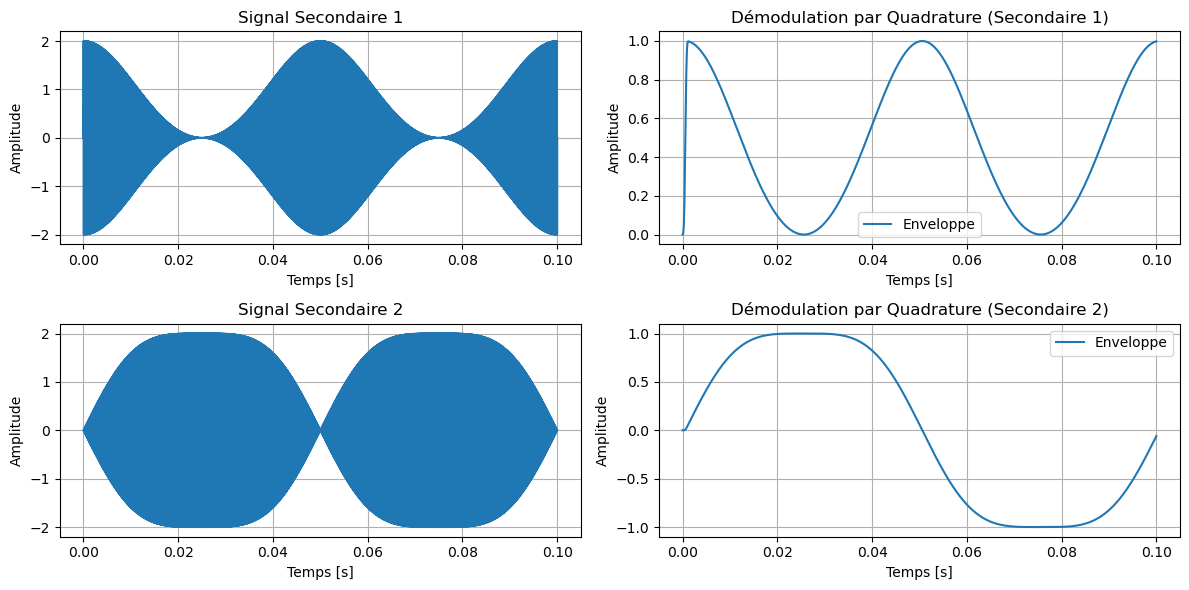

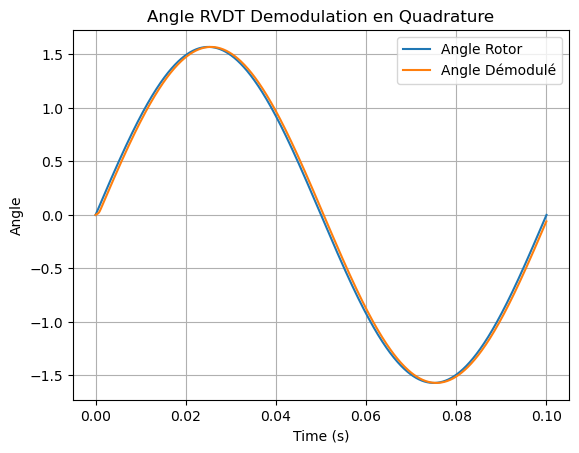

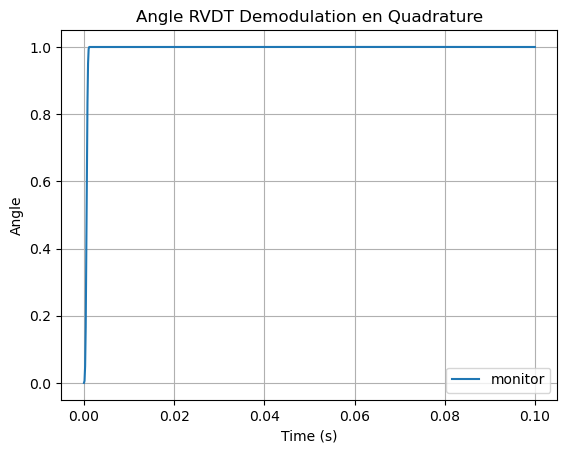

In [17]:
fs         = 10000000
exc_freq   = 10000
duration   = 0.1
angle_freq = 10
max_angle_deg = 90

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=0.0,
    noise_std=0.0
)

R, N, M = 1300, 3, 3

amp1, I1, Q1, new_t, x1, y1 = quadrature_demod(s1, exc_freq, fs, R, N, M)
amp2, I2, Q2, new_t, x2, y2 = quadrature_demod(s2, exc_freq, fs, R, N, M)

# Basic trigonometry
demod_angle_rad = np.unwrap(np.arctan2(Q2, Q1))

demod_angle_deg = np.rad2deg(np.unwrap(demod_angle_rad))
angle_rad = np.deg2rad(angle_deg)

monitor = Q1 * np.cos(demod_angle_rad) + Q2 * np.sin(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, Q1, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Quadrature (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, Q2, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Quadrature (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.plot(t, angle_rad, label="Angle Rotor")
plt.xlabel("Temps (s)")
plt.ylabel("Angle")
plt.title("Angle du Rotor RVDT simulé")
plt.grid(True)
plt.legend()

plt.plot(new_t, demod_angle_rad, label="Angle Démodulé")
plt.xlabel("Time (s)")
plt.ylabel("Angle")
plt.title("Angle RVDT Demodulation en Quadrature")
plt.grid(True)
plt.legend()

plt.show()

plt.plot(new_t, monitor, label="monitor")
plt.xlabel("Time (s)")
plt.ylabel("Angle")
plt.title("Angle RVDT Demodulation en Quadrature")
plt.grid(True)
plt.legend()

plt.show()

### fonctionnement avec noise

1.999999699354912
0.6840394773078462


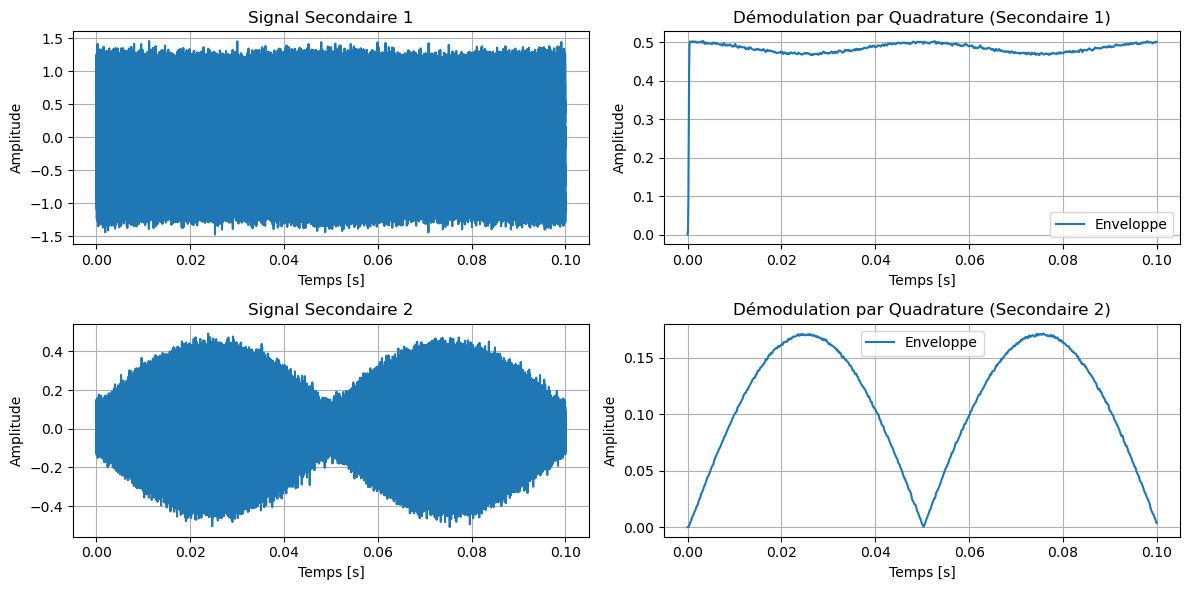

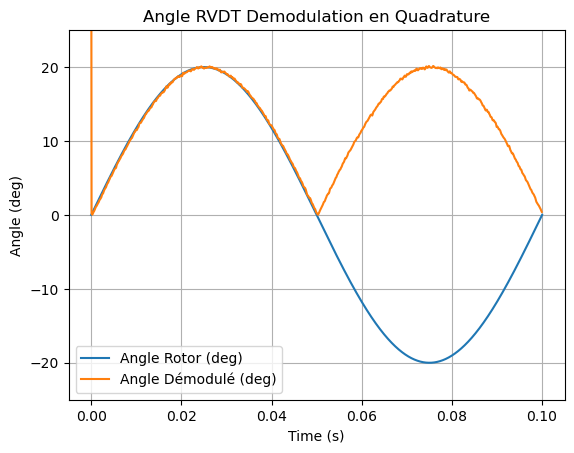

In [18]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1        
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 0.0
noise_std = 6.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

R, N, M = 800, 3, 2

amp1, I1, Q1, new_t, _, _ = quadrature_demod(s1, exc_freq, fs, R, N, M)
amp2, I2, Q2, new_t, _, _ = quadrature_demod(s2, exc_freq, fs, R, N, M)

# Basic trigonometry
demod_angle_rad = np.arctan2(amp2, amp1)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, amp1, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Quadrature (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, amp2, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Quadrature (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle du Rotor RVDT simulé")
plt.grid(True)
plt.legend()


plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle RVDT Demodulation en Quadrature")
plt.grid(True)
plt.ylim(-25, 25)
plt.legend()

plt.show()

### Fonctionnement avec un phase shift

1.999999699354912
0.6840394773078462


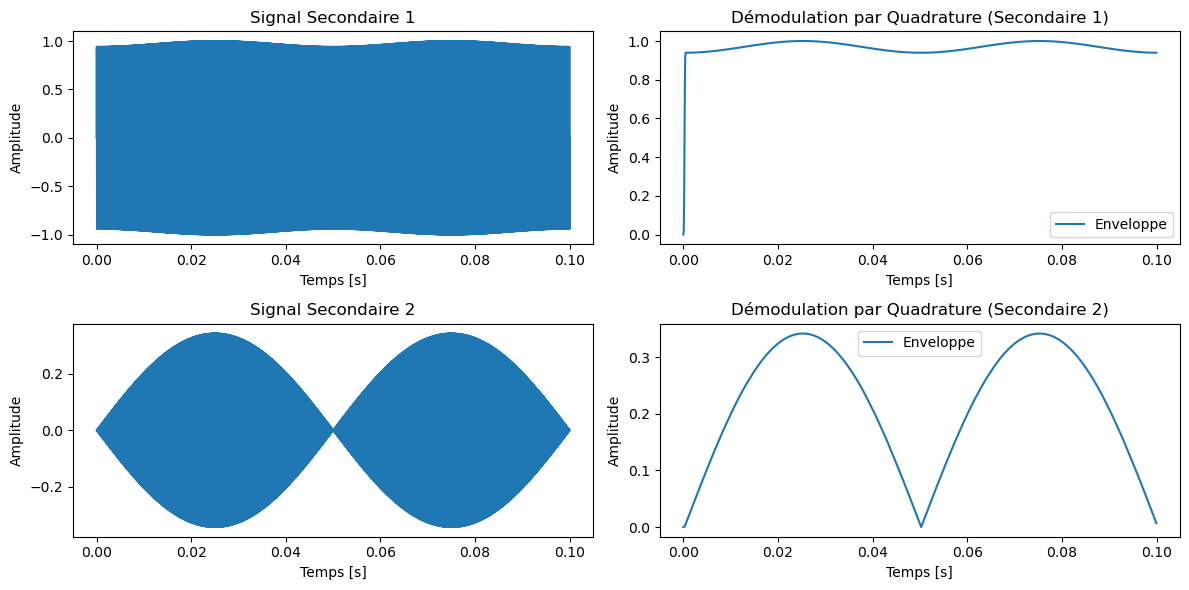

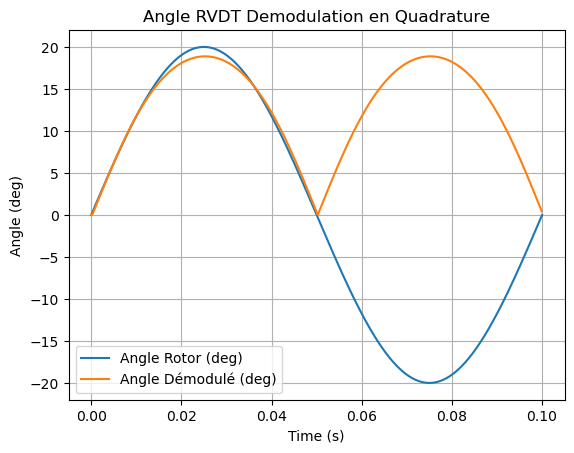

In [19]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1        
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 90.0
noise_std = 0.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

R, N, M = 800, 3, 2

amp1, I1, Q1, new_t, _, _ = quadrature_demod(s1, exc_freq, fs, R, N, M)
amp2, I2, Q2, new_t, _, _ = quadrature_demod(s2, exc_freq, fs, R, N, M)

# Basic trigonometry
demod_angle_rad = np.arctan2(amp2, amp1)
demod_angle_deg = np.rad2deg(demod_angle_rad)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")

axs[0, 1].plot(new_t, 2*amp1, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Quadrature (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")

axs[1, 1].plot(new_t, 2*amp2, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Quadrature (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle du Rotor RVDT simulé")
plt.grid(True)
plt.legend()


plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle RVDT Demodulation en Quadrature")
plt.grid(True)
plt.legend()

plt.show()

### Fonctionnement avec phase shift et noise

1.9999996845083046
0.6840394773078462


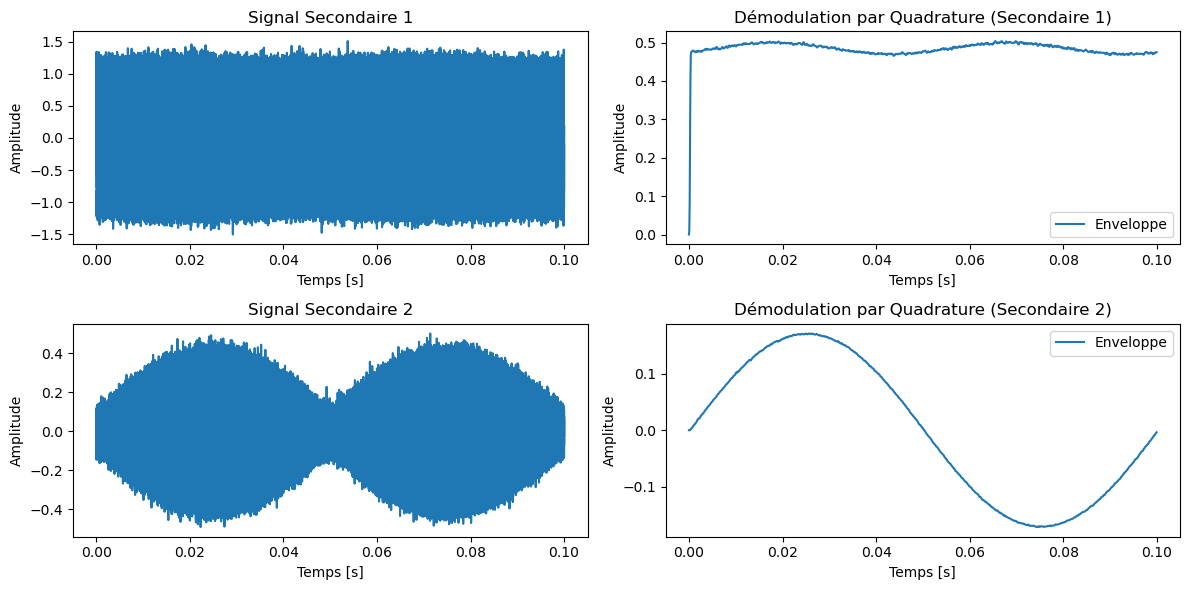

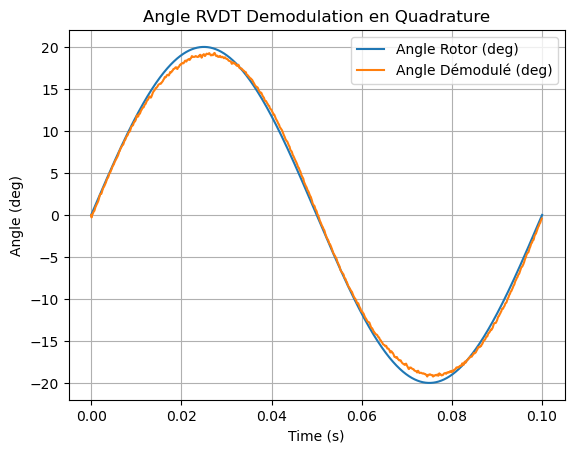

In [20]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1        
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 115.0
noise_std = 6.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

R, N, M = 800, 3, 2

amp1, I1, Q1, new_t, _, _ = quadrature_demod(s1, exc_freq, fs, R, N, M)
amp2, I2, Q2, new_t, _, _ = quadrature_demod(s2, exc_freq, fs, R, N, M)

# Basic trigonometry
demod_angle_rad = np.arctan2(Q2, Q1)
demod_angle_deg = np.rad2deg(demod_angle_rad)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")

axs[0, 1].plot(new_t, Q1, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Quadrature (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")

axs[1, 1].plot(new_t, Q2, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Quadrature (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle du Rotor RVDT simulé")
plt.grid(True)
plt.legend()

plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle RVDT Demodulation en Quadrature")
plt.grid(True)
plt.legend()

plt.show()

## PLL

### PLL algortihme

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter
import scipy.signal as signal

# see this link: https://wirelesspi.com/phase-locked-loop-pll-in-a-software-defined-radio-sdr/

def pll(sig, fs, f_init=5000.0, alpha=1e-3, beta=1e-4):

    n = len(sig)
    omega_init = 2.0*np.pi*f_init
    
    vco = np.zeros(n)
    err = np.zeros(n)
    
    phi_k = 0.0
    omega_k = omega_init
    
    for i in range(n):
        vco[i] = np.sin(phi_k)
        
        err[i] = sig[i] * vco[i]
        
        omega_k += beta * err[i]
        
        phi_k += (omega_k / fs) + alpha * err[i]
    
    return vco

def demodulate_pll(sig, fs, f_init, alpha, beta):
    
    vco = pll(sig, fs, f_init, alpha, beta)
    
    product = sig * vco
    R, N, M = 800, 3, 2
    demod = cic_decimate(product, R, N, M)
    new_t = t[::R]
    
    return demod, new_t

### Fonctionnement normal

1.999999699354912
0.6840394773078462


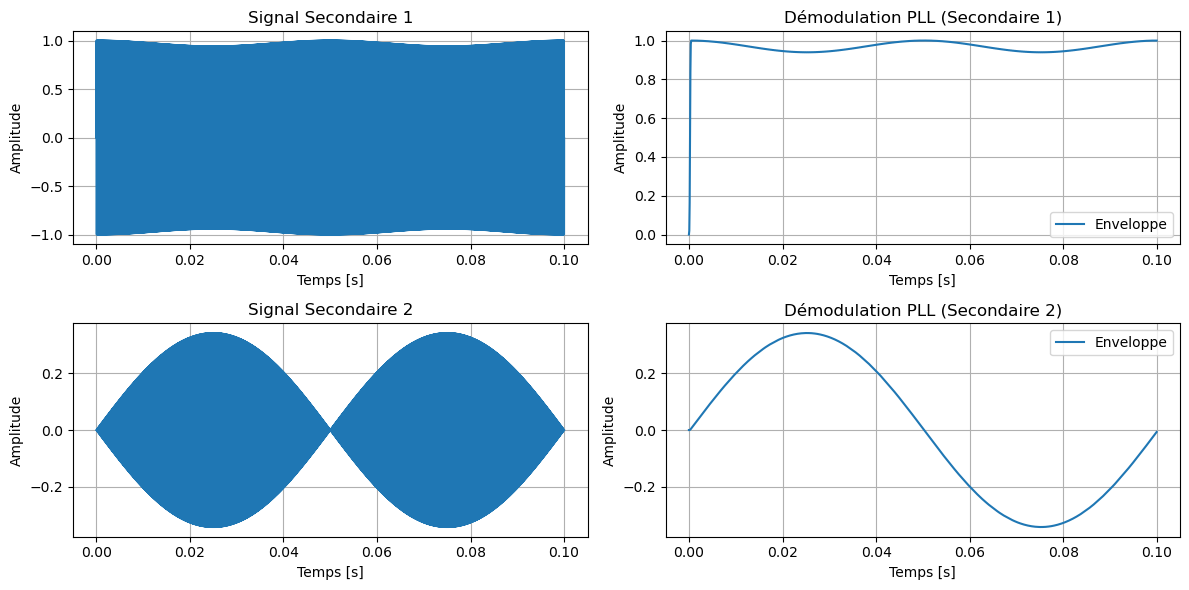

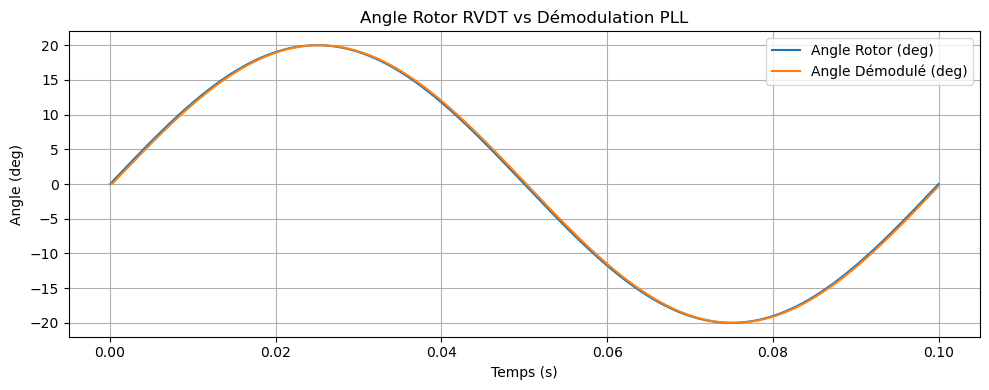

In [22]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1
angle_freq = 10 
max_angle_deg = 20      

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=0.0,
    noise_std=0.0
)

alpha = 1e-8
beta  = 1e-9
    
demod_s1, new_t = demodulate_pll(
    sig     = s1,
    fs      = fs,
    f_init  = exc_freq,
    alpha   = alpha,
    beta    = beta,
)
    
demod_s2, new_t = demodulate_pll(
    sig     = s2,
    fs      = fs,
    f_init  = exc_freq,
    alpha   = alpha,
    beta    = beta,
)

angle_rad = np.deg2rad(angle_deg)
true_env_s1 = 2.0*np.cos(angle_rad)
true_env_s2 = 2.0*np.sin(angle_rad)

demod_s1_x2 = 2 * demod_s1
demod_s2_x2 = 2 * demod_s2

demod_angle_rad = np.arctan2(demod_s2_x2, demod_s1_x2)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, demod_s1_x2, label="Enveloppe")
axs[0, 1].set_title("Démodulation PLL (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, demod_s2_x2, label="Enveloppe")
axs[1, 1].set_title("Démodulation PLL (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle Rotor RVDT vs Démodulation PLL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Fonctionnement avec noise

1.999999699354912
0.6840394773078462


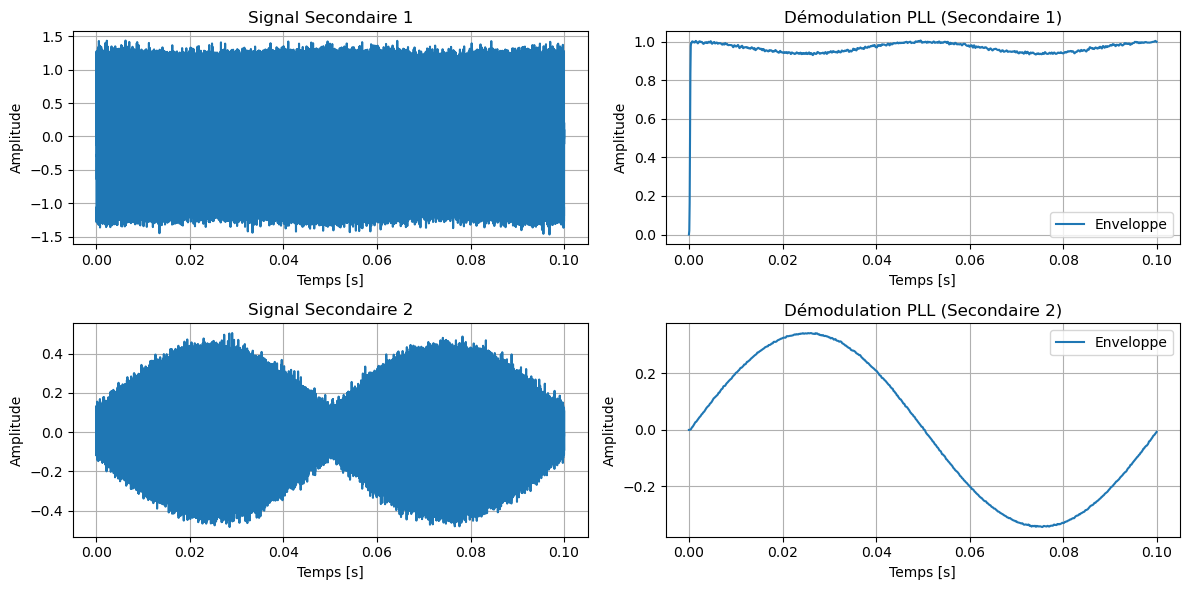

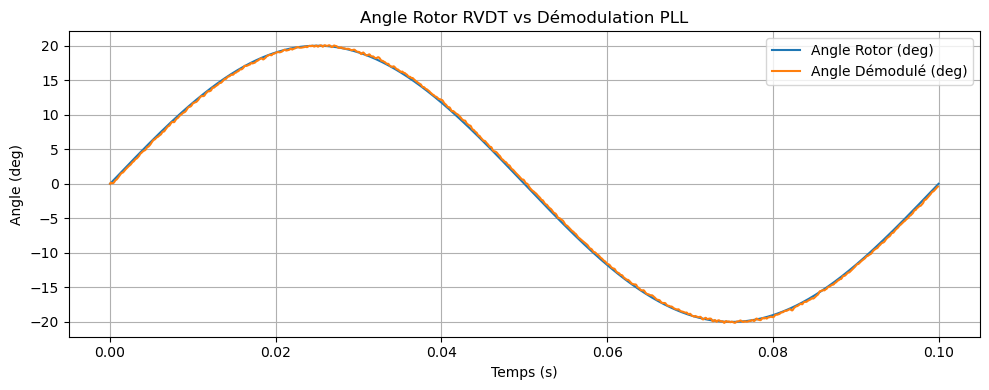

In [23]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1       
angle_freq = 10        
max_angle_deg = 20   
noise_std = 6.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=0.0,
    noise_std=noise_std
)

alpha = 1e-8
beta  = 1e-9
    
demod_s1, new_t = demodulate_pll(
    sig     = s1,
    fs      = fs,
    f_init  = exc_freq,
    alpha   = alpha,
    beta    = beta,
)
    
demod_s2, new_t = demodulate_pll(
    sig     = s2,
    fs      = fs,
    f_init  = exc_freq,
    alpha   = alpha,
    beta    = beta,
)

angle_rad = np.deg2rad(angle_deg)
true_env_s1 = 2.0*np.cos(angle_rad)
true_env_s2 = 2.0*np.sin(angle_rad)

demod_s1_x2 = 2 * demod_s1
demod_s2_x2 = 2 * demod_s2

demod_angle_rad = np.arctan2(demod_s2_x2, demod_s1_x2)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, demod_s1_x2, label="Enveloppe")
axs[0, 1].set_title("Démodulation PLL (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, demod_s2_x2, label="Enveloppe")
axs[1, 1].set_title("Démodulation PLL (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle Rotor RVDT vs Démodulation PLL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Fonctionnement avec phase shift

3.999999398709824
1.3680789546156924


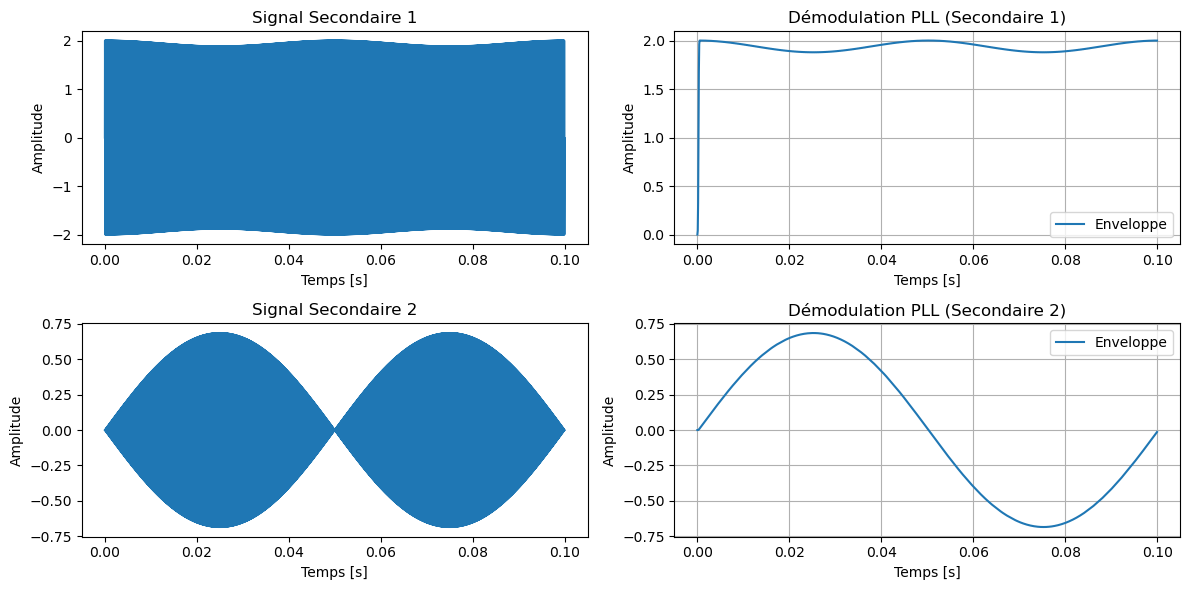

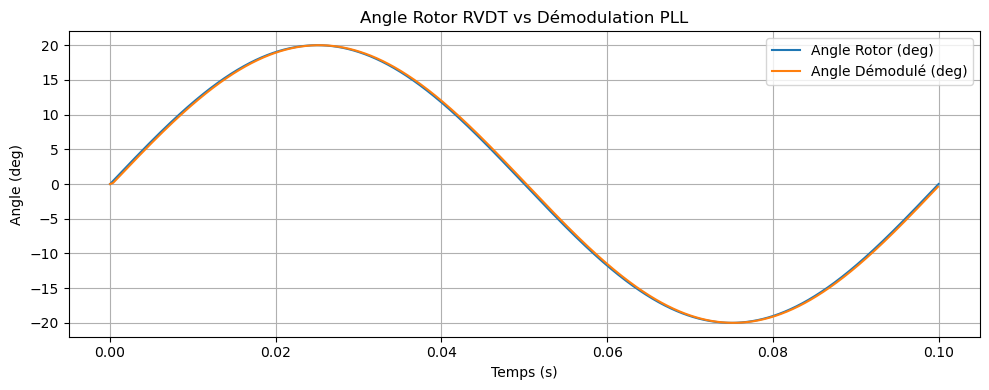

In [24]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1       
angle_freq = 10        
max_angle_deg = 20 
phase_shift_deg = 180.0
noise_std = 0.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

alpha = 1e-8
beta  = 1e-9
    
demod_s1, new_t = demodulate_pll(
    sig     = s1,
    fs      = fs,
    f_init  = exc_freq,
    alpha   = alpha,
    beta    = beta
)
    
demod_s2, new_t = demodulate_pll(
    sig     = s2,
    fs      = fs,
    f_init  = exc_freq,
    alpha   = alpha,
    beta    = beta
)

angle_rad = np.deg2rad(angle_deg)
true_env_s1 = 2.0*np.cos(angle_rad)
true_env_s2 = 2.0*np.sin(angle_rad)

demod_s1_x2 = 2 * demod_s1
demod_s2_x2 = 2 * demod_s2

demod_angle_rad = np.arctan2(demod_s2_x2, demod_s1_x2)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")

axs[0, 1].plot(new_t, demod_s1_x2, label="Enveloppe")
axs[0, 1].set_title("Démodulation PLL (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")

axs[1, 1].plot(new_t, demod_s2_x2, label="Enveloppe")
axs[1, 1].set_title("Démodulation PLL (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle Rotor RVDT vs Démodulation PLL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Fonctionnement avec noise et phase shift

3.999999369016609
1.3680789546156924


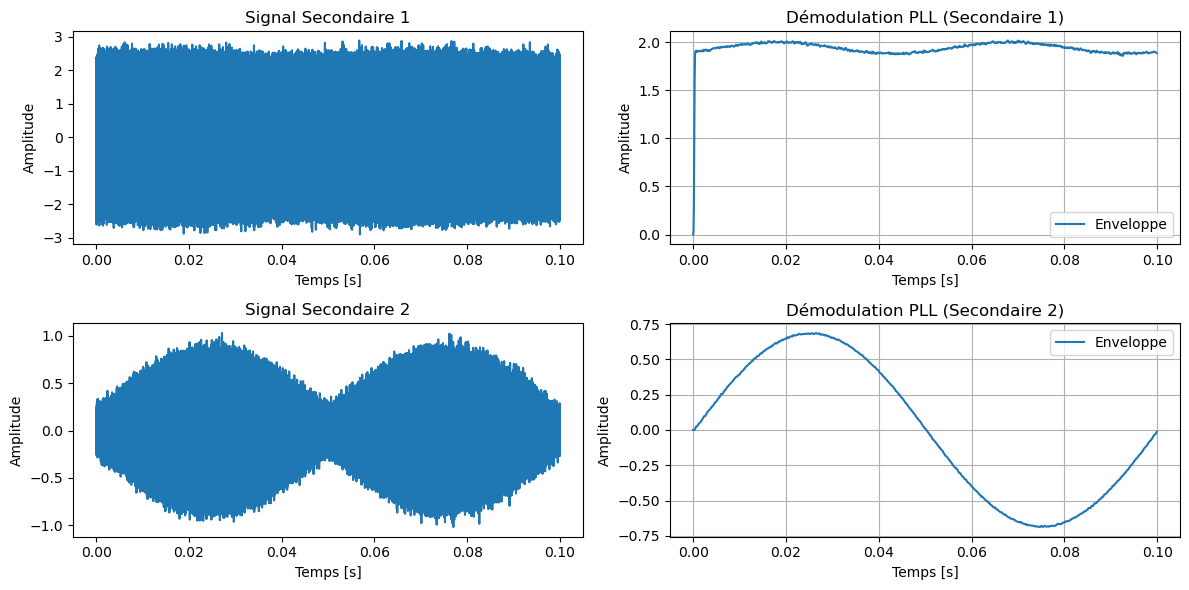

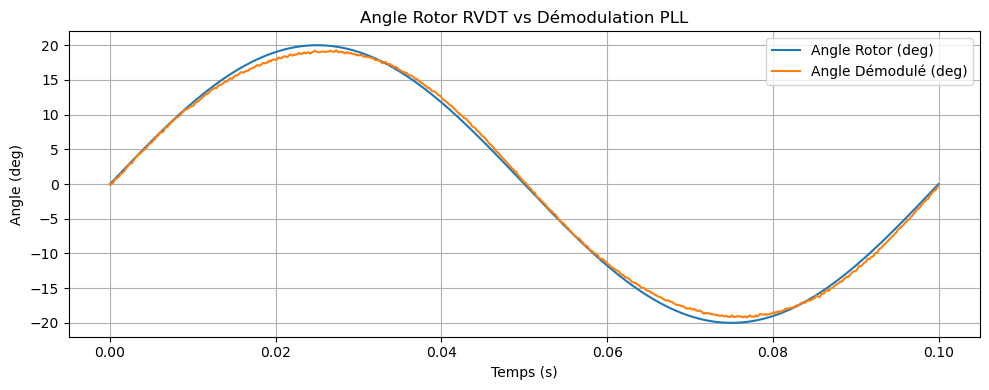

In [25]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1       
angle_freq = 10        
max_angle_deg = 20 
phase_shift_deg = 115.0
noise_std = 6.0


t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

alpha = 1e-8
beta  = 1e-9
    
demod_s1, new_t = demodulate_pll(
    sig     = s1,
    fs      = fs,
    f_init  = exc_freq,
    alpha   = alpha,
    beta    = beta
)
    
demod_s2, new_t = demodulate_pll(
    sig     = s2,
    fs      = fs,
    f_init  = exc_freq,
    alpha   = alpha,
    beta    = beta
)

angle_rad = np.deg2rad(angle_deg)
true_env_s1 = 2.0*np.cos(angle_rad)
true_env_s2 = 2.0*np.sin(angle_rad)

demod_s1_x2 = 2 * demod_s1
demod_s2_x2 = 2 * demod_s2

demod_angle_rad = np.arctan2(demod_s2_x2, demod_s1_x2)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")

axs[0, 1].plot(new_t, demod_s1_x2, label="Enveloppe")
axs[0, 1].set_title("Démodulation PLL (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")

axs[1, 1].plot(new_t, demod_s2_x2, label="Enveloppe")
axs[1, 1].set_title("Démodulation PLL (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle Rotor RVDT vs Démodulation PLL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Costas Loop

### Costas loop algorithm

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter, lfilter_zi
import scipy.signal as signal

# see this link https://dsp.stackexchange.com/questions/27446/doing-analysis-using-iq-demodulation-in-python

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def costas_loop(sig, fs, carrier, f_init=5000.0, alpha=1e-3, beta=1e-4, cutoff=200.0, order=5):
    n = len(sig)
    omega_init = 2.0*np.pi*f_init
    
    i_demod = np.zeros(n)
    q_demod = np.zeros(n)
    i_filt  = np.zeros(n)
    q_filt  = np.zeros(n)
    
    phi_k = 0.0
    omega_k = omega_init

    b, a = butter(order, cutoff/(0.5*fs), btype='low', analog=False)

    zi_i = lfilter_zi(b, a) * 0.0
    zi_q = lfilter_zi(b, a) * 0.0

    for i in range(n):
        cos_phi = np.cos(phi_k)
        sin_phi = np.sin(phi_k)
        
        i_now = sig[i] * cos_phi
        q_now = sig[i] * (-sin_phi)

        i_demod[i] = i_now
        q_demod[i] = q_now

        i_out, zi_i = lfilter(b, a, [i_now], zi=zi_i)
        q_out, zi_q = lfilter(b, a, [q_now], zi=zi_q)

        i_filt[i] = i_out[0]
        q_filt[i] = q_out[0]
        
        err = i_filt[i] * q_filt[i]
        
        omega_k += beta * err
        
        phi_k += (omega_k / fs) + alpha * err

        X = cos_phi * carrier[i]

        if X < 0:
            i_demod[i] = -i_demod[i]
            q_demod[i] = -q_demod[i]
    
    return i_demod, q_demod

def demodulate_costas(sig, fs, t, f_init=5000.0, alpha=1e-3, beta=1e-4,
                      cutoff=200.0, order=5):
    carrier = np.sin(2 * np.pi * f_init * t)
    i_brut, q_brut = costas_loop(sig, fs, carrier, f_init, alpha, beta, cutoff, order)
    
    # b, a = butter(order, cutoff/(0.5*fs), btype='low')
    # i_filt = filtfilt(b, a, i_brut)
    # q_filt = filtfilt(b, a, q_brut)

    R, N, M = 800, 3, 2
    i_filt = cic_decimate(i_brut, R, N, M)
    q_filt = cic_decimate(q_brut, R, N, M)
    
    amplitude = np.sign(i_filt) * np.sqrt(i_filt**2 + q_filt**2)
    phase = np.arctan2(q_filt, i_filt)
    
    new_t = t[::R]
    return i_filt, q_filt, amplitude, new_t 

### Fonctionnement normal

1.999999699354912
0.6840394773078462


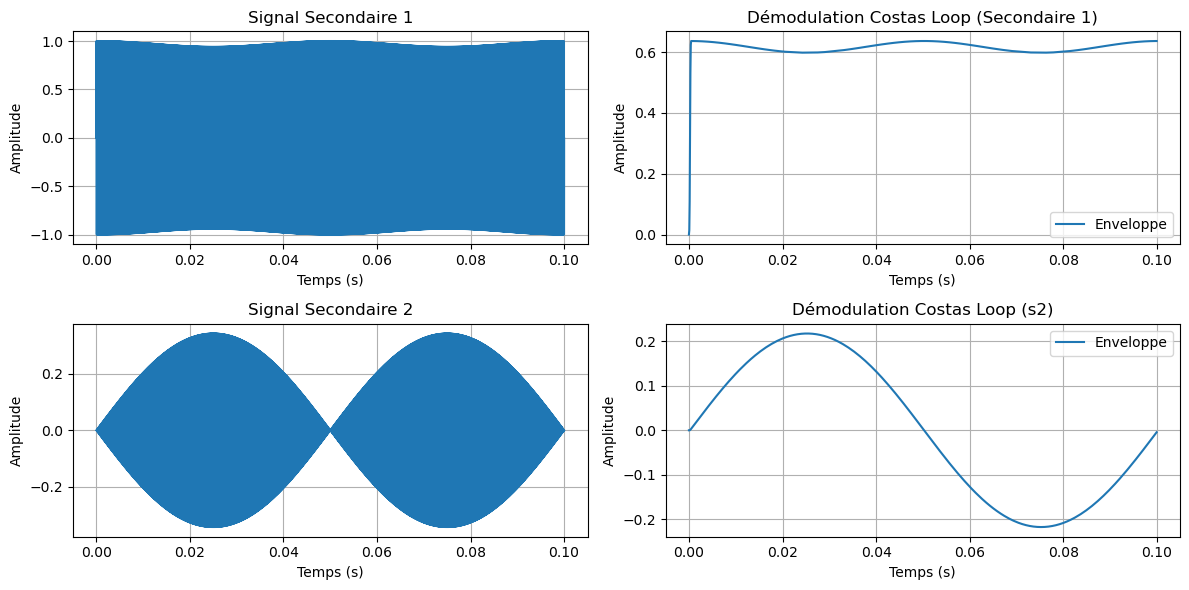

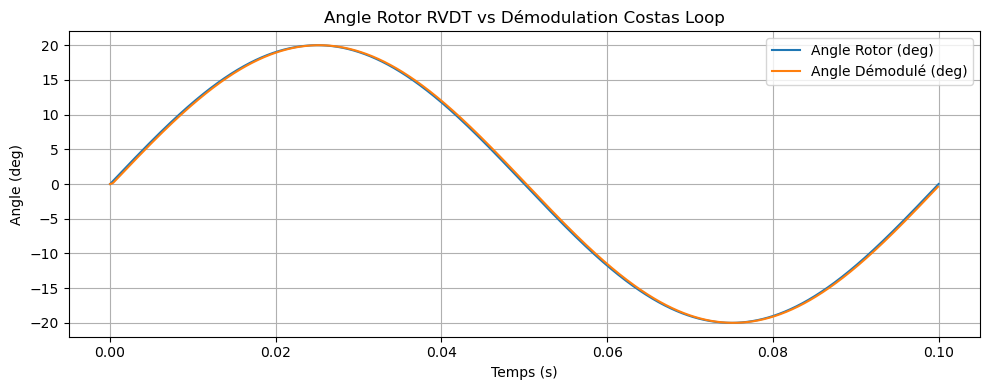

In [27]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1       
angle_freq = 10        
max_angle_deg = 20      

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=1.0,
    phase_shift_deg=0.0,
    noise_std=0.0
)

order = 5
alpha = 1e-6
beta  = 1e-7
cutoff = 10000.0
    
i_s1, q_s1, amp_s1, new_t = demodulate_costas(
    sig = s1,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

i_s2, q_s2, amp_s2, new_t = demodulate_costas(
    sig = s2,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

demod_angle_rad = np.arctan2(amp_s2, amp_s1)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps (s)")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, 2 * amp_s1, label="Enveloppe")
axs[0, 1].set_title("Démodulation Costas Loop (Secondaire 1)")
axs[0, 1].set_xlabel("Temps (s)")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps (s)")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, 2 * amp_s2, label="Enveloppe")
axs[1, 1].set_title("Démodulation Costas Loop (s2)")
axs[1, 1].set_xlabel("Temps (s)")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle Rotor RVDT vs Démodulation Costas Loop")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Fonctionnement avec noise

#### Version sans filtre avant démodulation

3.999999398709824
1.3680789546156924


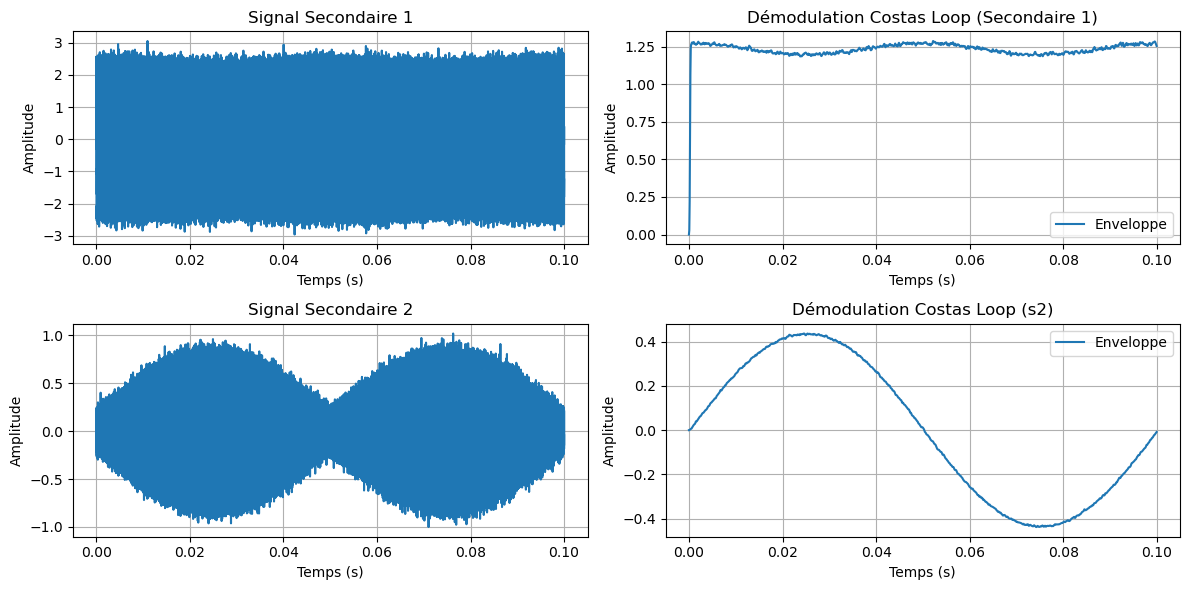

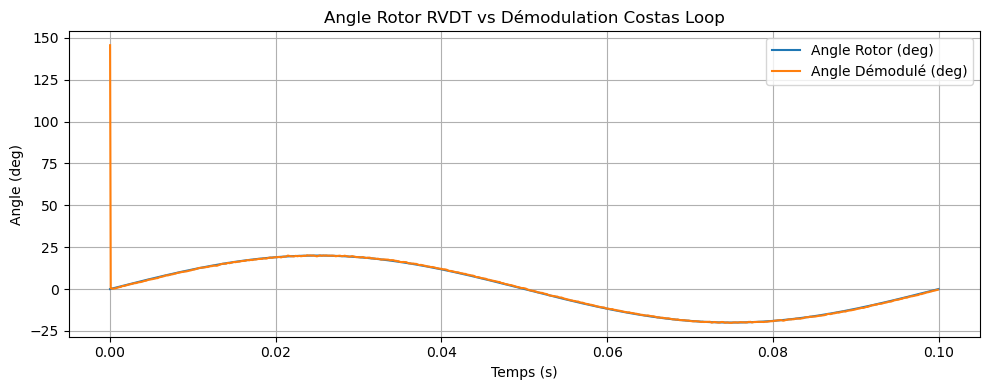

In [28]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1       
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 0.0
noise_std = 6.0


t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

order = 5
alpha = 1e-6
beta  = 1e-7
cutoff = 4000.0

i_s1, q_s1, amp_s1, new_t = demodulate_costas(
    sig = s1,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

i_s2, q_s2, amp_s2, new_t = demodulate_costas(
    sig = s2,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

demod_angle_rad = np.arctan2(amp_s2, amp_s1)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps (s)")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, 2 * amp_s1, label="Enveloppe")
axs[0, 1].set_title("Démodulation Costas Loop (Secondaire 1)")
axs[0, 1].set_xlabel("Temps (s)")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps (s)")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, 2 * amp_s2, label="Enveloppe")
axs[1, 1].set_title("Démodulation Costas Loop (s2)")
axs[1, 1].set_xlabel("Temps (s)")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle Rotor RVDT vs Démodulation Costas Loop")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Version avec filtre avant démodulation

3.999999398709824
1.3680789546156924
3.999999398709824
1.3680789546156924


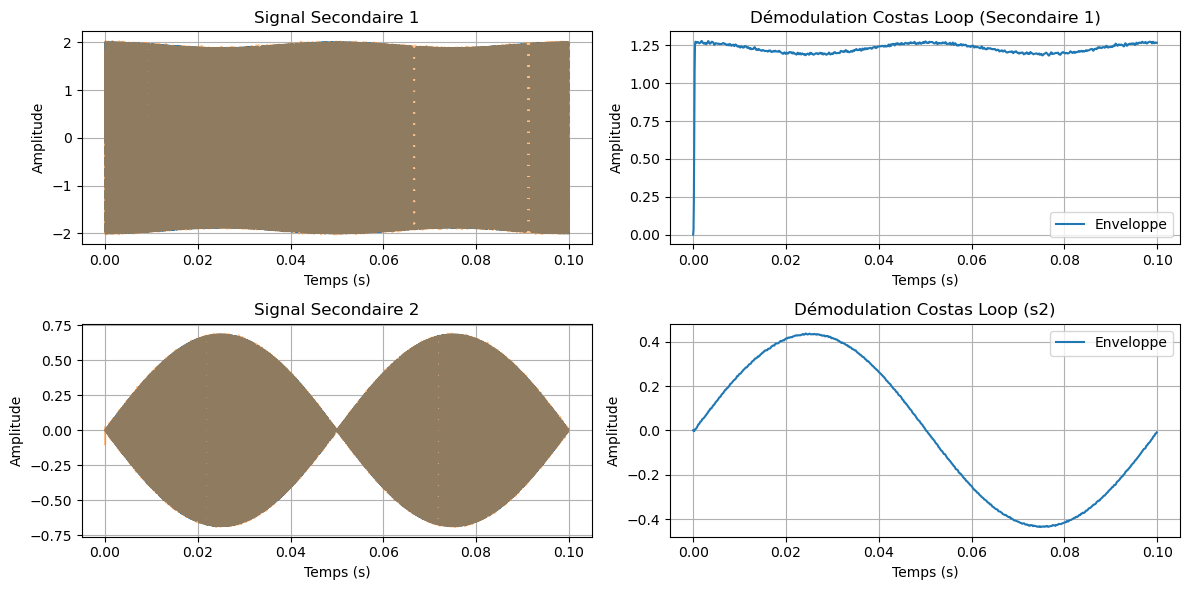

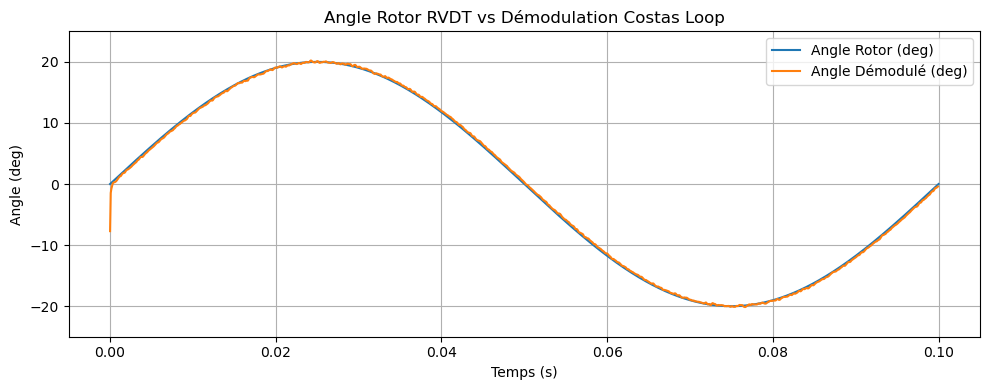

In [29]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1       
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 0.0
noise_std = 6.0


t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

t, angle_deg, s1_nn, s2_nn = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=0.0
)

order = 5

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

alpha = 1e-6
beta  = 1e-7
cutoff = 4000.0
lowcut = 7000
highcut = 13000
cutoff2 = 18000

#s1_filt = butter_bandpass_filter(s1, lowcut, highcut, fs, 3)
#s2_filt = butter_bandpass_filter(s2, lowcut, highcut, fs, 3)

b, a = butter(order, cutoff2/(0.5*fs), btype='low')
s1_filt = filtfilt(b, a, s1)
s2_filt = filtfilt(b, a, s2)
    
i_s1, q_s1, amp_s1, new_t = demodulate_costas(
    sig = s1_filt,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

i_s2, q_s2, amp_s2, new_t = demodulate_costas(
    sig = s2_filt,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

demod_angle_rad = np.arctan2(amp_s2, amp_s1)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1_nn, linestyle = 'dashed')
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps (s)")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 0].plot(t, s1_filt, alpha=0.5)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps (s)")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, 2 * amp_s1, label="Enveloppe")
axs[0, 1].set_title("Démodulation Costas Loop (Secondaire 1)")
axs[0, 1].set_xlabel("Temps (s)")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2_nn, linestyle = 'dashed')
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps (s)")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 0].plot(t, s2_filt, alpha=0.5)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps (s)")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, 2 * amp_s2, label="Enveloppe")
axs[1, 1].set_title("Démodulation Costas Loop (s2)")
axs[1, 1].set_xlabel("Temps (s)")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.ylim(-25, 25)
plt.title("Angle Rotor RVDT vs Démodulation Costas Loop")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Fonctionnement avec phase shift

3.999999398709824
1.3680789546156924


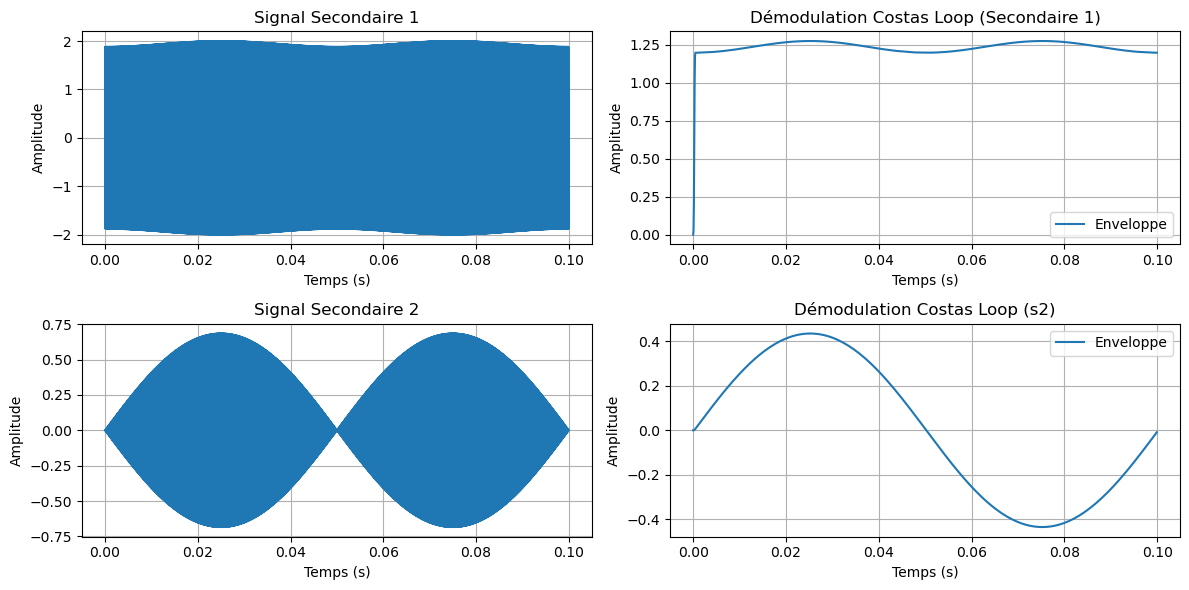

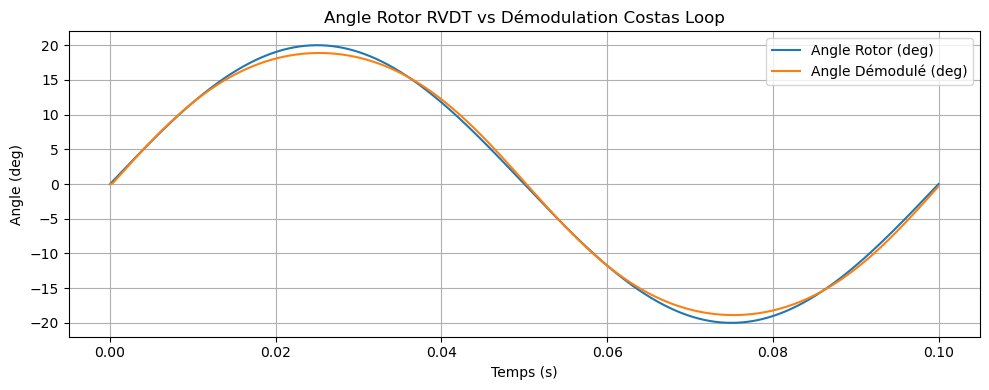

In [30]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1       
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 90.0
noise_std = 0.0


t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

order = 5
alpha = 1e-6
beta  = 1e-7
cutoff = 4000.0
    
i_s1, q_s1, amp_s1, new_t = demodulate_costas(
    sig = s1,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

i_s2, q_s2, amp_s2, new_t = demodulate_costas(
    sig = s2,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

demod_angle_rad = np.arctan2(i_s2, i_s1)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps (s)")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, 2 * i_s1, label="Enveloppe")
axs[0, 1].set_title("Démodulation Costas Loop (Secondaire 1)")
axs[0, 1].set_xlabel("Temps (s)")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps (s)")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, 2 * i_s2, label="Enveloppe")
axs[1, 1].set_title("Démodulation Costas Loop (s2)")
axs[1, 1].set_xlabel("Temps (s)")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle Rotor RVDT vs Démodulation Costas Loop")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Fonctionnement avec noise et phase shift

3.999999369016609
1.3680789546156924


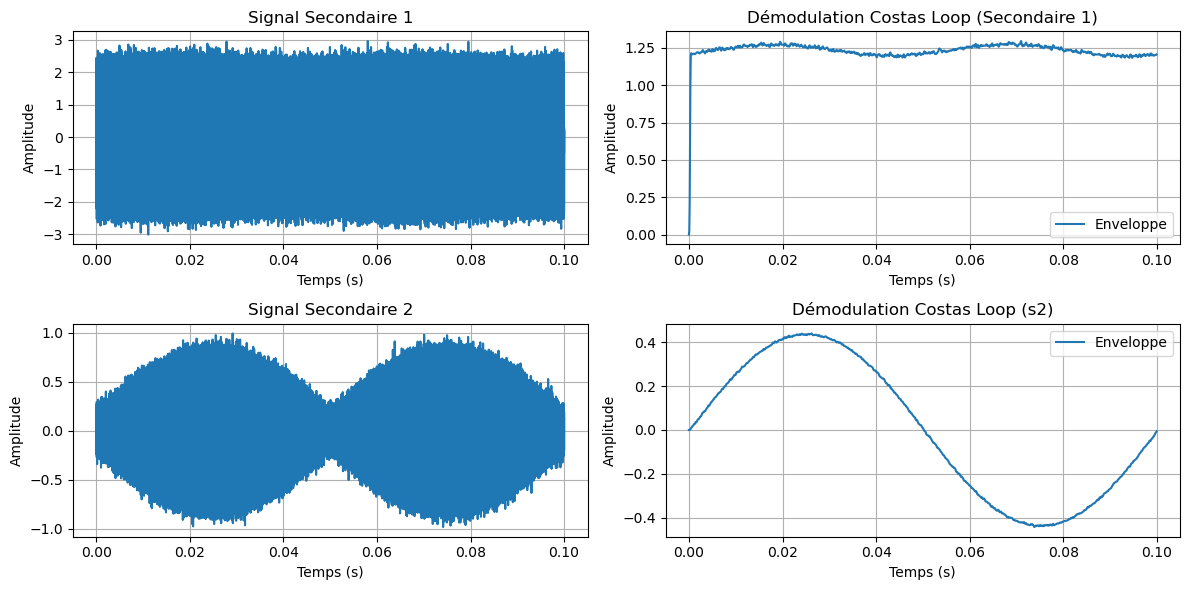

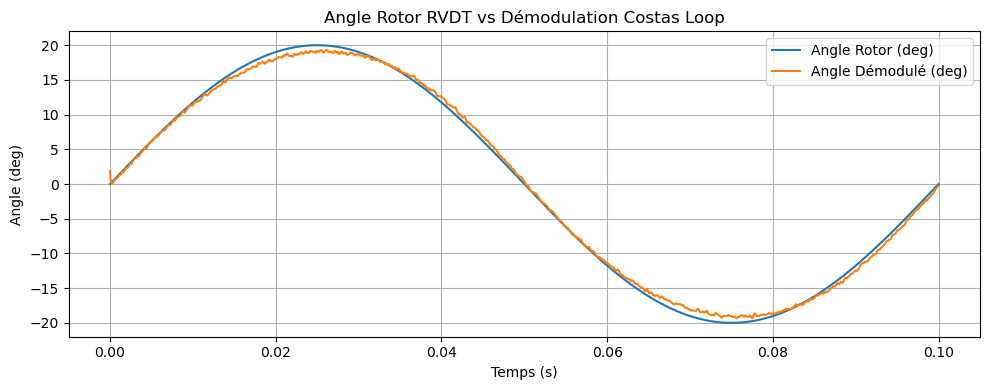

In [31]:
fs         = 10000000   
exc_freq   = 10000    
duration   = 0.1       
angle_freq = 10        
max_angle_deg = 20     
phase_shift_deg = 115.0
noise_std = 6.0

t, angle_deg, s1, s2 = simulate_rvdt(
    sample_rate=fs,
    duration=duration,
    exc_freq=exc_freq,
    angle_freq=angle_freq,
    max_angle_deg=max_angle_deg,
    gain=2.0,
    phase_shift_deg=phase_shift_deg,
    noise_std=noise_std
)

order = 5
alpha = 1e-6
beta  = 1e-7
cutoff = 4000.0
    
i_s1, q_s1, amp_s1, new_t = demodulate_costas(
    sig = s1,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

i_s2, q_s2, amp_s2, new_t = demodulate_costas(
    sig = s2,
    fs  = fs,
    t = t,
    f_init = exc_freq,
    alpha  = alpha,
    beta   = beta,
    cutoff = cutoff,
    order  = order
)

demod_angle_rad = np.arctan2(amp_s2, amp_s1)
demod_angle_deg = np.rad2deg(demod_angle_rad)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t, s1)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps (s)")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, 2 * amp_s1, label="Enveloppe")
axs[0, 1].set_title("Démodulation Costas Loop (Secondaire 1)")
axs[0, 1].set_xlabel("Temps (s)")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t, s2)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps (s)")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, 2 * amp_s2, label="Enveloppe")
axs[1, 1].set_title("Démodulation Costas Loop (s2)")
axs[1, 1].set_xlabel("Temps (s)")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, angle_deg, label="Angle Rotor (deg)")
plt.plot(new_t, demod_angle_deg, label="Angle Démodulé (deg)")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (deg)")
plt.title("Angle Rotor RVDT vs Démodulation Costas Loop")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Real signal

## Load file

In [32]:
import os
import re
import h5py
import numpy as np
import matplotlib.pyplot as plt

data_dir        = "hdf5"      
dataset_sin     = "IdAd9257Ch3"
dataset_cos     = "IdAd9257Ch4"
fs              = 1250000 

def list_hdf5_by_angle(folder):
    # https://docs.python.org/3/howto/regex.html
    all_files = re.compile(r"resolverAt([0-9.]+)rad", re.IGNORECASE)
    hits = []
    for fn in os.listdir(folder):
        m = all_files.search(fn)
        if m:
            angle = float(m.group(1))
            hits.append((angle, fn))
    return sorted(hits, key=lambda x: x[0])

def load_vector(path, dset_name):
    with h5py.File(path, "r") as f:
        for key in f.keys():
            if key.endswith(dset_name):
                vec = np.asarray(f[key])
                break
        else:
            raise KeyError(f"{dset_name} not found in {path}")
    return vec

## Load and concatenate signal

### Ugly signal (not in phase and in amplitude sync)

In [33]:
angles_sorted = list_hdf5_by_angle(data_dir)
if not angles_sorted:
    raise RuntimeError("No resolverAt*.hdf5 files found in", data_dir)

sin_full   = []
cos_full   = []
angle_full = []

for idx, (ang_rad, fname) in enumerate(angles_sorted):
    fpath = os.path.join(data_dir, fname)
    sin_vec = load_vector(fpath, dataset_sin)
    cos_vec = load_vector(fpath, dataset_cos)

    sin_full.extend(sin_vec)
    cos_full.extend(cos_vec)
    angle_full.extend(np.full(len(sin_vec), ang_rad))

sin_full   = np.asarray(sin_full,   dtype=np.float64)
cos_full   = np.asarray(cos_full,   dtype=np.float64)
angle_full = np.asarray(angle_full, dtype=np.float64)

sin_full -= np.mean(sin_full)
cos_full -= np.mean(cos_full)

t_full = np.arange(len(sin_full)) / fs

print("Concatenated sweep length  :", len(sin_full), "samples")
print("Duration                   :", t_full[-1], "seconds")
print("Angle range (rad)          :", angle_full.min(), "→", angle_full.max())

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(t_full, sin_full, label="Secondary‑1 (sin)")
ax[0].set_ylabel("ADC counts")
ax[0].set_title("Concatenated raw secondary signals")
#ax[0].set_xlim(0.006, 0.008)
ax[0].legend(loc="upper right")
ax[0].grid()

ax[1].plot(t_full, cos_full, label="Secondary‑2 (cos)")
ax[1].set_ylabel("ADC counts")
ax[1].set_title("Concatenated raw secondary signals")
ax[1].legend(loc="upper right")
ax[1].grid()

plt.tight_layout()
plt.show()

plt.plot(t_full, angle_full, "k")
plt.xlabel("Time [s]")
plt.ylabel("Rotor angle [rad]")
plt.title("Angle sweep assembled from real captures")
plt.grid()

plt.tight_layout()
plt.show()

OSError: Unable to open file (file signature not found)

### Smooth signal

In [ ]:
angles_sorted = list_hdf5_by_angle(data_dir)
if not angles_sorted:
    raise RuntimeError("No resolverAt*.hdf5 files found in", data_dir)

angle_full = []
for ang_rad, fname in angles_sorted:
    fpath = os.path.join(data_dir, fname)
    sin_vec = load_vector(fpath, dataset_sin)   # just to get length
    angle_full.extend(np.full(len(sin_vec), ang_rad))
angle_full = np.asarray(angle_full, dtype=np.float64)

def nco(fcw, acw, sr):
    phase = 0.0
    out   = np.empty_like(fcw, dtype=np.float64)
    for i, f in enumerate(fcw):
        phase += 2*np.pi * f / sr
        # wrap phase every 2*pi to avoid numerical explosion
        if phase > 2*np.pi:
            phase -= 2*np.pi * np.floor(phase/(2*np.pi))
        out[i] = acw[i] * np.cos(phase)
    return out

carrier_freq = 10000.0  

fcw       = np.full_like(angle_full, carrier_freq)
acw_sin   = np.sin(angle_full)  
acw_cos   = np.cos(angle_full)  

sin_full = nco(fcw, acw_sin, fs)
cos_full = nco(fcw, acw_cos, fs)

sin_full -= np.mean(sin_full)
cos_full -= np.mean(cos_full)

t_full = np.arange(len(sin_full)) / fs

print("Concatenated sweep length  :", len(sin_full), "samples")
print("Duration                   :", t_full[-1], "seconds")
print("Angle range (rad)          :", angle_full.min(), "→", angle_full.max())

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(t_full, sin_full, label="Secondary‑1 (sin)")
ax[0].set_ylabel("ADC counts")
ax[0].set_title("Concatenated raw secondary signals")
#ax[0].set_xlim(0.006, 0.008)
ax[0].legend(loc="upper right")
ax[0].grid()

ax[1].plot(t_full, cos_full, label="Secondary‑2 (cos)")
ax[1].set_ylabel("ADC counts")
ax[1].set_title("Concatenated raw secondary signals")
ax[1].legend(loc="upper right")
ax[1].grid()

plt.tight_layout()
plt.show()

plt.plot(t_full, angle_full, "k")
plt.xlabel("Time [s]")
plt.ylabel("Rotor angle [rad]")
plt.title("Angle sweep assembled from real captures")
plt.grid()

plt.tight_layout()
plt.show()

## Quadrature and output

In [ ]:
R, N, M = 200, 3, 2
exc_freq = 10000

amp1, I1, Q1, new_t = quadrature_demod(sin_full, exc_freq, fs, R, N, M)
amp2, I2, Q2, new_t = quadrature_demod(cos_full, exc_freq, fs, R, N, M)

# Basic trigonometry
demod_angle_rad = np.unwrap(np.arctan2(I1, I2))
demod_angle_deg = np.rad2deg(np.unwrap(demod_angle_rad))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].plot(t_full, sin_full)
axs[0, 0].set_title("Signal Secondaire 1")
axs[0, 0].set_xlabel("Temps [s]")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].grid(True)

axs[0, 1].plot(new_t, Q1, label='Enveloppe')
axs[0, 1].set_title("Démodulation par Quadrature (Secondaire 1)")
axs[0, 1].set_xlabel("Temps [s]")
axs[0, 1].set_ylabel("Amplitude")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(t_full, cos_full)
axs[1, 0].set_title("Signal Secondaire 2")
axs[1, 0].set_xlabel("Temps [s]")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].grid(True)

axs[1, 1].plot(new_t, Q2, label='Enveloppe')
axs[1, 1].set_title("Démodulation par Quadrature (Secondaire 2)")
axs[1, 1].set_xlabel("Temps [s]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.plot(t_full, angle_full, label="Angle Rotor")
plt.xlabel("Temps (s)")
plt.ylabel("Angle")
plt.title("Angle du Rotor RVDT simulé")
plt.grid(True)
plt.legend()

plt.plot(new_t, demod_angle_rad, label="Angle Démodulé")
plt.xlabel("Time (s)")
plt.ylabel("Angle")
plt.title("Angle RVDT Demodulation en Quadrature")
plt.grid(True)
plt.legend()

plt.show()

# For the report

<Figure size 1200x1600 with 0 Axes>

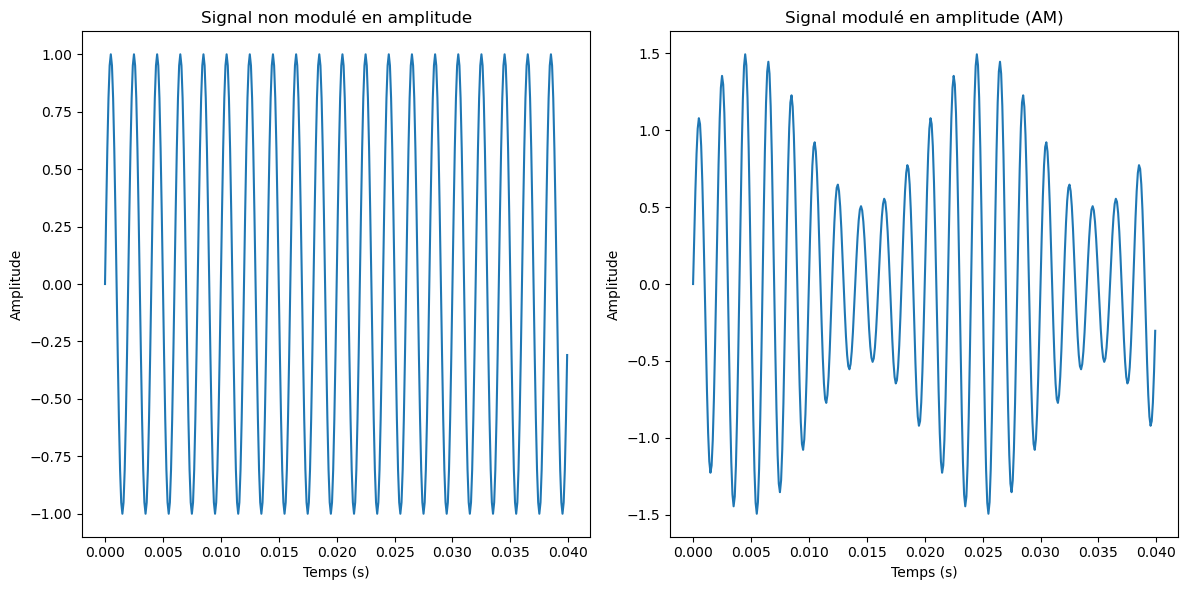

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du signal
fs = 10000  # Fréquence d'échantillonnage (Hz)
fc = 500    # Fréquence de la porteuse (Hz)
fm = 50      # Fréquence du signal modulant (Hz)
Am = 1       # Amplitude du signal modulant
Ac = 1       # Amplitude de la porteuse
m = 0.5      # Indice de modulation (entre 0 et 1)
duration = 0.04  # Durée du signal (s)

# Vecteur temps
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Signal modulant
modulating_signal = Am * np.sin(2 * np.pi * fm * t)

# Porteuse
carrier = Ac * np.sin(2 * np.pi * fc * t)

# Signal AM généré
am_signal = (1 + m * modulating_signal) * carrier

# Affichage des résultats
plt.figure(figsize=(12, 16))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axs[0].plot(t, carrier)
axs[0].set_title('Signal non modulé en amplitude')
axs[0].set_xlabel('Temps (s)')
axs[0].set_ylabel('Amplitude')

axs[1].plot(t, am_signal)
axs[1].set_title('Signal modulé en amplitude (AM)')
axs[1].set_xlabel('Temps (s)')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

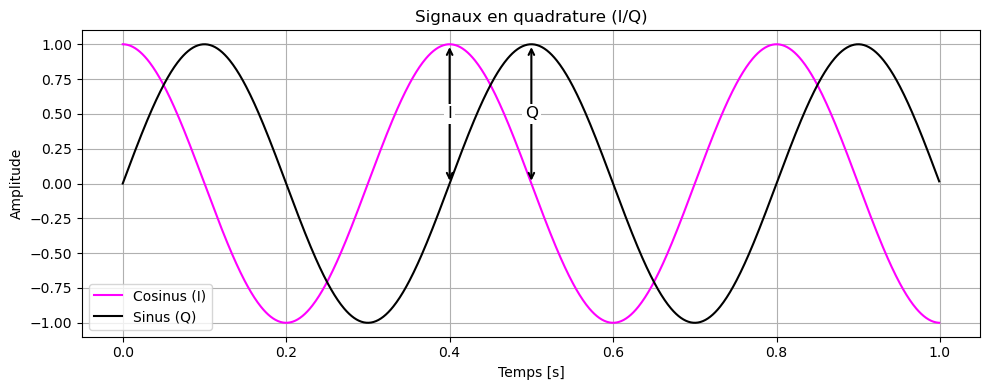

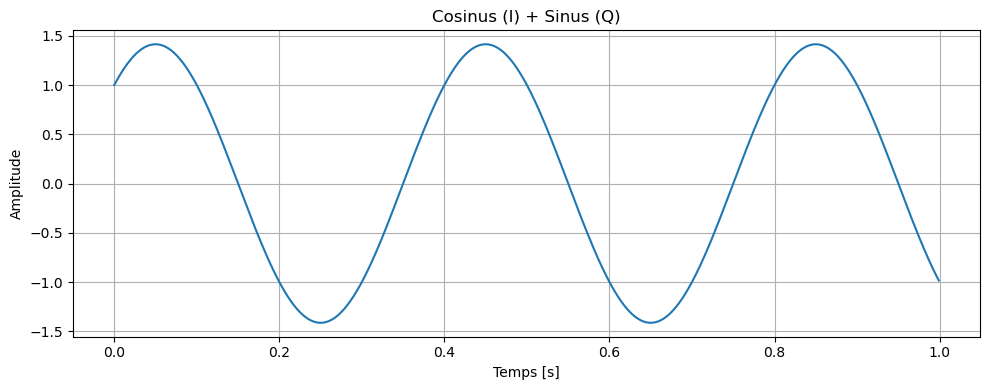

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000
f = 2.5
duration = 1
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Generate signals
signal_cos = np.cos(2 * np.pi * f * t)
signal_sin = np.sin(2 * np.pi * f * t)
quad_result = signal_cos + signal_sin

# Create plot
plt.figure(figsize=(10, 4))
plt.plot(t, signal_cos, label='Cosinus (I)', color='magenta')
plt.plot(t, signal_sin, label='Sinus (Q)', color='black')

# Choose time positions for arrows
x_I = 0.4
x_Q = 0.5

# Arrow for I
y_I_top = signal_cos[int(x_I * fs)]
y_I_bottom = 0
plt.annotate('', xy=(x_I, y_I_top), xytext=(x_I, y_I_bottom), arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
plt.text(x_I, (y_I_top + y_I_bottom)/2, 'I', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

# Arrow for Q
y_Q_top = signal_sin[int(x_Q * fs)]
y_Q_bottom = 0
plt.annotate('', xy=(x_Q, y_Q_top), xytext=(x_Q, y_Q_bottom), arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
plt.text(x_Q, (y_Q_top + y_Q_bottom)/2, 'Q', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

# Graph config
plt.title('Signaux en quadrature (I/Q)')
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t, quad_result)
plt.title('Cosinus (I) + Sinus (Q)')
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1200x1600 with 0 Axes>

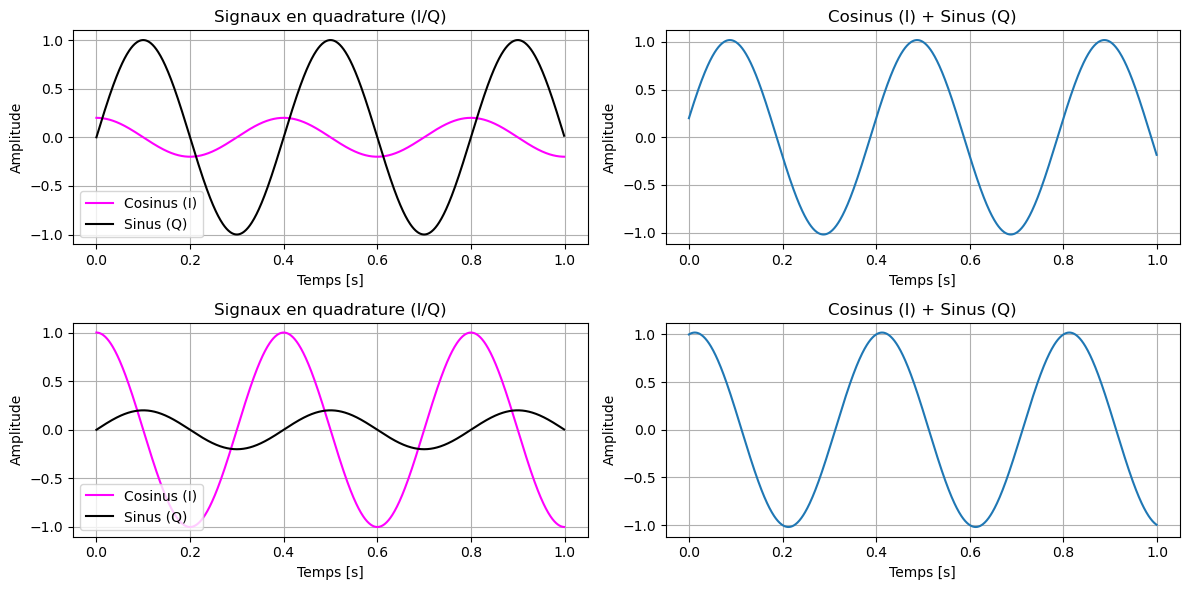

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000
f = 2.5
duration = 1
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Generate signals
signal_cos = 0.2 * np.cos(2 * np.pi * f * t)
signal_sin = np.sin(2 * np.pi * f * t)
quad_result = signal_cos + signal_sin

# Generate signals
signal_cos2 = np.cos(2 * np.pi * f * t)
signal_sin2 = 0.2 * np.sin(2 * np.pi * f * t)
quad_result2 = signal_cos2 + signal_sin2

plt.figure(figsize=(12, 16))
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Graph config
axs[0, 0].plot(t, signal_cos, label='Cosinus (I)', color='magenta')
axs[0, 0].plot(t, signal_sin, label='Sinus (Q)', color='black')
axs[0, 0].set_title('Signaux en quadrature (I/Q)')
axs[0, 0].set_xlabel('Temps [s]')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 0].grid(True)
axs[0, 0].legend(loc='lower left')

axs[0, 1].plot(t, quad_result)
axs[0, 1].set_title('Cosinus (I) + Sinus (Q)')
axs[0, 1].set_xlabel('Temps [s]')
axs[0, 1].set_ylabel('Amplitude')
axs[0, 1].grid(True)

# Graph config
axs[1, 0].plot(t, signal_cos2, label='Cosinus (I)', color='magenta')
axs[1, 0].plot(t, signal_sin2, label='Sinus (Q)', color='black')
axs[1, 0].set_title('Signaux en quadrature (I/Q)')
axs[1, 0].set_xlabel('Temps [s]')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 0].grid(True)
axs[1, 0].legend(loc='lower left')

axs[1, 1].plot(t, quad_result2)
axs[1, 1].set_title('Cosinus (I) + Sinus (Q)')
axs[1, 1].set_xlabel('Temps [s]')
axs[1, 1].set_ylabel('Amplitude')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


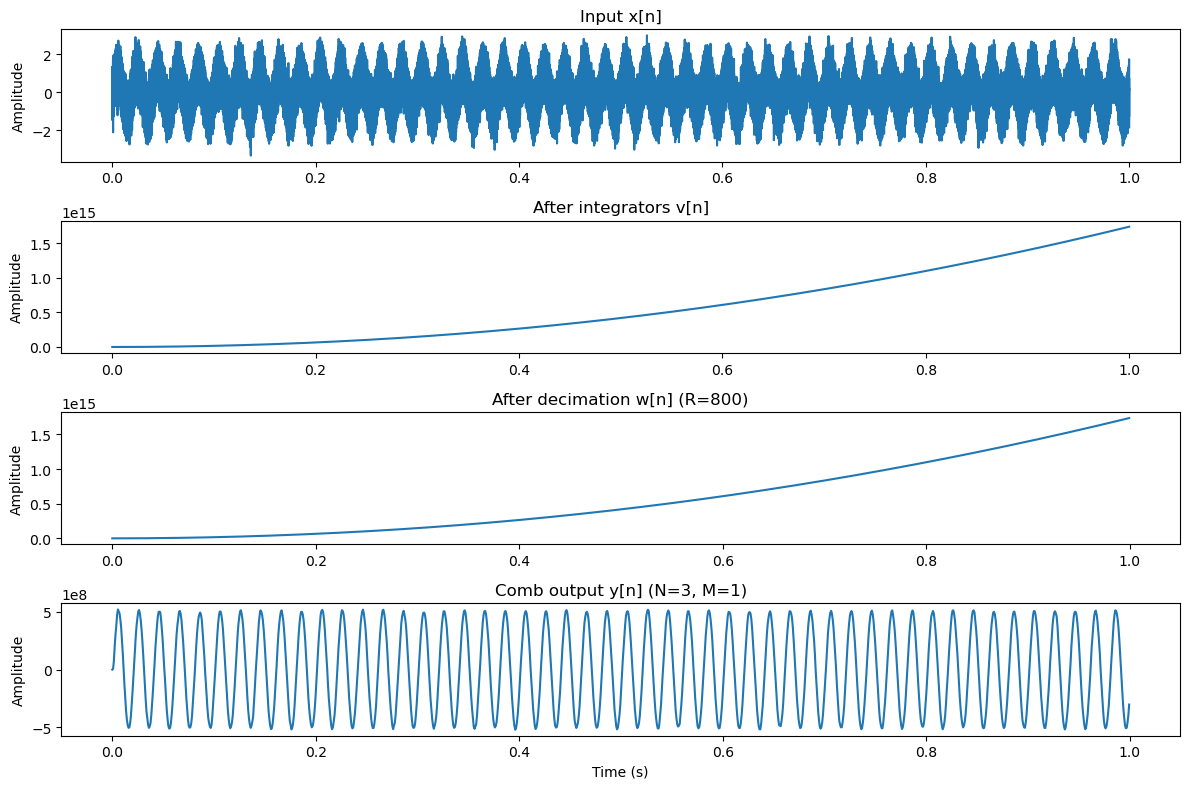

In [40]:
import numpy as np
import matplotlib.pyplot as plt

fs       = 1_000_000      # sampling rate (Hz)
f_signal = 50             # sine frequency (Hz)
N        = 3              # CIC order
R        = 800            # decimation factor
M        = 1              # comb delay
duration = 1              # seconds

t  = np.arange(0, duration, 1/fs)
x  = np.sin(2*np.pi*f_signal*t) + 0.5*np.random.randn(t.size)

v = x.copy()
for _ in range(N):
    v = np.cumsum(v)

w            = v[::R]
t_decimated  = t[::R]

y = w.copy()
for _ in range(N):
    y = np.append([0]*M, y[M:] - y[:-M])

plt.figure(figsize=(12, 8))

plt.subplot(4,1,1); plt.plot(t, x)
plt.title("Input x[n]"); plt.ylabel("Amplitude")

plt.subplot(4,1,2); plt.plot(t, v)
plt.title("After integrators v[n]"); plt.ylabel("Amplitude")

plt.subplot(4,1,3); plt.plot(t_decimated, w)
plt.title(f"After decimation w[n] (R={R})"); plt.ylabel("Amplitude")

plt.subplot(4,1,4); plt.plot(t_decimated, y)
plt.title(f"Comb output y[n] (N={N}, M={M})"); plt.xlabel("Time (s)"); plt.ylabel("Amplitude")

plt.tight_layout(); plt.show()